In [1]:
# imports
import os
import sys
import cv2
import numpy as np
import subprocess
import pyexif
from pathlib import Path

sys.path.append('..')

from utils.log_utils import log
from utils.multiview_utils import Camera
from utils.metadata_utils import get_cam_names
from configs.arguments import get_config_dict
from utils.io_utils import write_json


arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')

In [2]:
# Load cameras
try:
    config = get_config_dict()
except:
    log.warning("No config file found. Using default values.")
    config = {}
    
data_root = Path(config.get('main', {}).get('data_root', '/root/data'))
omni_tag = config.get('calibration', {}).get('omni_tag', '360')
# data_root = Path(config.get('main', {}).get('data_root', '/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data'))
# set up paths
env_footage = data_root / 'raw_data' / 'footage'
opensfm_data =  data_root / '0-calibration' / 'opensfm'
opensfm_images = opensfm_data / 'images'
extrinsics_path = data_root / '0-calibration' / 'extrinsics'

cams = get_cam_names(env_footage)
camera_models_overrides_dict = {}
log.info(f"Found {(cams)} in environment footage.")
len_360 = 0
sample_images = []
for cam in cams:
    camera = Camera(cam, newest=False)
    if omni_tag in camera.name:
        omni_cam = camera
        len_360 = len(camera)
        omni_imgs = camera.extract(range(0, len_360, 30))
        continue
    sample_images.append(camera.extract([10])[0])



14:19:03.588 - [...calibration/../configs/arguments.py:093] - DEBUG    - No training config file specified, using default config in data_root/2-training/train_config.yaml
14:19:03.589 - [           0-calibration/4133907889.py:019] - INFO     - Found ['cam1', 'cam2', 'cam3', 'cam360'] in environment footage.
14:19:03.777 - [...bration/../utils/multiview_utils.py:653] - WARNING  - Unable to read JSON /Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/calibs/cam360.json, initialising with default values
14:19:03.777 - [...bration/../utils/multiview_utils.py:655] - WARNING  - [Errno 2] No such file or directory: '/Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/calibs/cam360.json'


IntSlider(value=0, max=740)

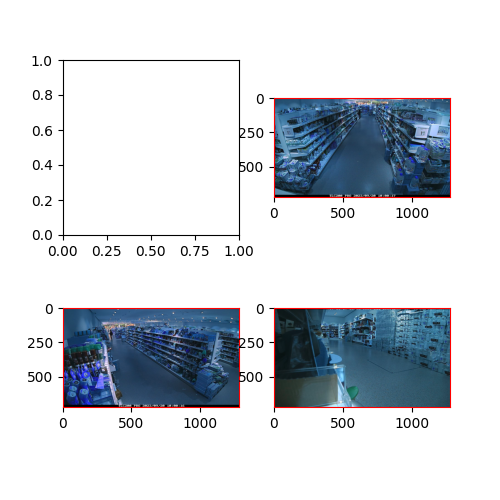

In [46]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import math
%matplotlib widget
# Assuming you have a list of lists of images, where each sublist corresponds to a camera
# images = [...]  # replace this with your actual list of images

# Calculate the number of rows and columns for the subplot grid
num_cameras = len(sample_images)
grid_size = math.ceil(math.sqrt(num_cameras))

# A dictionary to store selected frames for each camera and a list to store toggle states
selected_frames = {f'cam{i+1}': [] for i in range(len(sample_images))}
toggle_states = [False] * num_cameras  # Initially all cameras are toggled on



# Create figure and axes for the images
fig, axarr = plt.subplots(grid_size, grid_size, figsize=(5, 5))
axarr = axarr.flatten()
frame_index = 0
# Function to update the image for the first camera
def update_first_camera(change):
    global frame_index
    # print(change)
    frame_index = change['new']
    # print(current_frame)
    # img = omni_cam.extract([current_frame])[0]
    # print(img.shape)
    axarr[0].imshow(omni_imgs[frame_index])
    plt.draw()

# Function to handle clicks on camera images
# def on_click(event, cam_index, frame_index):
#     if event.inaxes in axarr[cam_index].get_children():
#         if cam_index == 0:
#             # Toggle state for the first camera does not affect frame selection
#             return
#         if toggle_states[cam_index]:
#             # Camera is on, add the frame index
#             selected_frames[f'cam{cam_index+1}'].append(frame_index)
#         else:
#             # Toggle the state of the camera
#             toggle_states[cam_index] = not toggle_states[cam_index]
#             axarr[cam_index].spines['top'].set_color('green' if toggle_states[cam_index] else 'red')
#             axarr[cam_index].spines['bottom'].set_color('green' if toggle_states[cam_index] else 'red')
#             axarr[cam_index].spines['left'].set_color('green' if toggle_states[cam_index] else 'red')
#             axarr[cam_index].spines['right'].set_color('green' if toggle_states[cam_index] else 'red')
#             plt.draw()

def create_on_click_function(cam_index):
    global frame_index
    def on_click(event):
        # print(event)
        if event.inaxes == axarr[cam_index]:
            # print(event)
            # print(f"Clicked on camera {cam_index} at frame {frame_index}")
            if cam_index == 0:
                return
            toggle_states[cam_index - 1] = not toggle_states[cam_index - 1]
            selected_frames[f'cam{cam_index}'].append(frame_index * 30)
            color = 'green' if toggle_states[cam_index - 1] else 'red'
            for spine in axarr[cam_index].spines.values():
                spine.set_color(color)
            plt.draw()
    return on_click

def set_subplot_border_color(ax, is_on):
    """
    Set the color of the border of the subplot based on the toggle state.
    
    :param ax: The axis of the subplot.
    :param is_on: A boolean indicating the toggle state.
    """
    color = 'green' if is_on else 'red'
    for spine in ax.spines.values():
        spine.set_color(color)



# Display initial images and setup event handlers
for j in range(num_cameras):
    i = j + 1
    axarr[i].imshow(sample_images[j])
    # axarr[i].axis('off')
    set_subplot_border_color(axarr[i], toggle_states[j])
    on_click_function = create_on_click_function(i)
    axarr[i].figure.canvas.mpl_connect('button_press_event', on_click_function)


# Hide unused subplots
for i in range(num_cameras + 1, grid_size**2):
    axarr[i].axis('off')

# Create a slider for the first camera
slider = widgets.IntSlider(min=0, max=len(omni_imgs), step=1, value=0)
slider.observe(update_first_camera, names='value')

# Display the slider
display(slider)


In [48]:
selected_frames

{'cam1': [840, 3240, 5010, 9420],
 'cam2': [4920, 5010, 7020, 9420],
 'cam3': [1260, 3240, 7020, 13710]}

In [61]:
def create_camera_subsets(cameras, total_length_360, fps_360):
    # Calculate the number of segments and segment length
    num_segments = total_length_360 / (fps_360 * 30)
    segment_length = total_length_360 / num_segments

    # Initialize data structure for camera subsets
    camera_subsets = [set() for _ in range(int(num_segments))]

    # Iterate over each camera and their time intervals
    for cam_id, time_intervals in cameras.items():
        for i in range(0, len(time_intervals), 2):
            if len(time_intervals) % 2 != 0:
                time_intervals.append(total_length_360)
            start_time, end_time = list(time_intervals)[i], list(time_intervals)[i+1]
            start_segment = int(start_time // segment_length)
            end_segment = int(end_time // segment_length)

            # Assign camera to the appropriate segment(s) and combine segments if necessary
            for segment in range(start_segment, end_segment + 1):
                camera_subsets[segment].add(cam_id)

    # Convert sets back to lists for easier use
    camera_subsets = [list(subset) for subset in camera_subsets]
    return_dict = {}
    for i, item in enumerate(camera_subsets):
        return_dict[f"segment_{i}"] = {"start_time" : segment_length * i, 
                          "end_time" : segment_length * (i+1) - 1, 
                          "cameras" : item}

    return return_dict

# total_length_360 = 3600  # Total length of 360 footage in seconds
fps_360 = 30  # Frame rate of the 360 footage

camera_subsets = create_camera_subsets(selected_frames, len_360, fps_360)

# save segments
write_json(extrinsics_path / 'selected_frames.json', camera_subsets)
log.info(f"Saved selected frames to {extrinsics_path / 'selected_frames.json'}")


15:18:23.582 - [           0-calibration/2623427509.py:039] - INFO     - Saved selected frames to /Users/grosche/Documents/GitHub/CVLAB/MARMOT/data/0-calibration/extrinsics/selected_frames.json
